# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Ivan Yovchev"
NAME2 = "Balint Hompot"
NAME3 = "Davide Barbieri"
EMAIL = "yovchev23@gmail.com"
EMAIL2 = "balint.hompot@student.uva.nl"
EMAIL3 = "davidebarbieri97@gmail.com"

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, September/October 2019

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [4]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [47]:
def gen_sine(n):
    
    # Sample inputs
    x = np.linspace(0, 2 * np.pi, num=n)
    
    # Compute respective targets (+ noise)
    t = np.random.normal(np.sin(x), 0.25)
    
    return x, t


In [48]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [49]:
def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    
    #      1, x_1, (x_1)^2 ...(x_1)^M
    #      1, x_2, (x_2)^2 ...(x_2)^M
    #Phi = 1, x_3, (x_3)^2 ...(x_3)^M
    #      ... ... ... ... ... ... ...
    #      1, x_n, (x_n)^2 ...(x_n)^M
    
    # reshape x so its a column vector
    x = np.asarray(x)
    x = x.reshape([x.shape[0],1])
    
    # same for Phi where first column
    # is only 1s as x^0 = 1
    Phi = np.ones([x.shape[0],1])
    
    # vec will be used to keep track of
    # the degree
    vec = x
    
    while M > 0:
        # add column vector to Phi
        Phi = np.append(Phi, vec, axis=1)
        
        # and raise the degree of vec
        vec = vec*x
        
        # update loop value
        M = M - 1
    
    return Phi

def fit_polynomial(x, t, M):
    
    # get feature matrix
    Phi = designmatrix(x,M)
    
    # calculate w_ml
    w_ml = np.dot(np.linalg.pinv(Phi), t)
    
    return w_ml, Phi


In [50]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

In [75]:
## Helper function to calculate polynomial
def build_polynomial(w, M, x):
    
    Phi = designmatrix(x, M)
    
    polynom = np.dot(Phi, np.transpose(w))
    
    return polynom
    

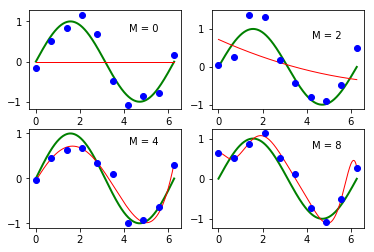

In [76]:
fig = plt.figure()

# plot enumerator
i = 1

for m in [0,2,4,8]:
    pl = fig.add_subplot(2,2,i)
    
    x, t = gen_sine(10)
    w, Phi = fit_polynomial(x, t, m)
    
    # get range of values on x-axis
    xx = np.arange(0.0, 2 * np.pi, 0.01)
    
    # plot true sin function
    y = np.sin(xx)
    pl.plot(xx, y, 'g', lw=2)

    # plot approximated sine
    y = build_polynomial(w, m, xx)
    pl.plot(xx, y, 'r', lw=1)
    
    # plot target points
    plt.plot(x, t, 'bo')
    
    plt.annotate('M = ' + str(m), xy=(4.25, 0.75))
    
    i = i+1
    
plt.show()

### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [97]:
def fit_polynomial_reg(x, t, m, lamb):
    
    # calculate design matrix
    Phi = designmatrix(x, m)
    
    # w_ml = (lamb * I + Phi^T * Phi)^(-1) * Phi^T * t
    inv = np.linalg.pinv(lamb * np.identity(Phi.shape[1]) + np.dot(np.transpose(Phi), Phi))
    w_ml = np.dot(np.dot(inv, np.transpose(Phi)), t)
    
    return w_ml, Phi


In [98]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

In [102]:
# Compare regularized with unregularized ML parameters

# Parameters
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1

# Unregularized fit
w1, Phi1 = fit_polynomial(x, t, m)

print(w1)
print(Phi1)

# Regularized fit
w2, Phi2 = fit_polynomial_reg(x, t, m, lamb)

print(w2)
print(Phi2)

[  2.50000000e+00   9.99200722e-16   3.00000000e-01]
[[ 1.         -1.          1.        ]
 [ 1.         -0.77777778  0.60493827]
 [ 1.         -0.55555556  0.30864198]
 [ 1.         -0.33333333  0.11111111]
 [ 1.         -0.11111111  0.01234568]
 [ 1.          0.11111111  0.01234568]
 [ 1.          0.33333333  0.11111111]
 [ 1.          0.55555556  0.30864198]
 [ 1.          0.77777778  0.60493827]
 [ 1.          1.          1.        ]]
[  2.45489460e+00  -3.60822483e-16   3.50456753e-01]
[[ 1.         -1.          1.        ]
 [ 1.         -0.77777778  0.60493827]
 [ 1.         -0.55555556  0.30864198]
 [ 1.         -0.33333333  0.11111111]
 [ 1.         -0.11111111  0.01234568]
 [ 1.          0.11111111  0.01234568]
 [ 1.          0.33333333  0.11111111]
 [ 1.          0.55555556  0.30864198]
 [ 1.          0.77777778  0.60493827]
 [ 1.          1.          1.        ]]


Phi is unchanged, as the feature matrix depends on the input data and the basis functions, but not on regularization. The regularization makes the parameters shrink towards 0 unless supported by the data: this is what we can observe, the ones that appear to be more significant in the model are not changed heavily (the bias and the quadratic term), but the one that does not seem to be meaningful in the model (the first order term) shrinks further to 0.






### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [108]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    
    # calculate w for the given data
    w, _Phi = fit_polynomial_reg(x_train, t_train, M, reg)
    
    # obtain design matrix for validation data
    Phi = designmatrix(x_valid, M)
    
    # Phi * w - t
    prediction_difference =  t_valid - np.dot(Phi, w)
    squared_err = np.dot(np.transpose(prediction_difference), prediction_difference)
    
    # E = 1/2 * (Phi * w - t)^T * (Phi * w - t) 
    pred_err = 0.5 * squared_err
    
    return pred_err


In [109]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [110]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [114]:
def find_best_m_and_lamb(x, t):
    
    # Parameters
    K = 5 # num of folds
    train_folds, valid_folds = kfold_indices(x.shape[0], K) #get indicies
    
    # Possible values for M and lambda
    M = [m for m in range(11)]
    lamb = [np.e**(-l) for l in reversed(range(11))]
    
    # variables to keep track of best values
    min_error = None
    M_best = None
    lamb_best = None
    
    for m in M:
        for l in lamb:
            # testing current set of M and lambda paramters
            error = 0
            
            for train_set, valid_set in zip(train_folds, valid_folds):
                
                # populate x and t for each fold according to index
                x_train = [x[i] for i in train_set]
                x_valid = [x[i] for i in valid_set]
                t_train = [t[i] for i in train_set]
                t_valid = [t[i] for i in valid_set]
                
                # calculate error using the given x, t, M and lambda
                error = error + pred_error(x_train, x_valid, t_train, t_valid, m, l)
                
            # average error over all K folds
            error = error / K
            
            # update if better values are found
            if min_error is None or error < min_error:
                min_error = error
                M_best = m
                lamb_best = l
            
    
    return M_best, lamb_best

# sanity check
x, t = gen_sine(10)
M_best, lamb_best = find_best_m_and_lamb(x,t)

print("Best M: ", M_best, "\tBest Lambda: ", lamb_best)

Best M:  3 	Best Lambda:  0.04978706836786395


In [115]:
### This is not an empty cell (You don't need to care about it).

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

This method would (probably) not lead us to a globally optimal solution, as the globally optimal value of one parameter is in most cases not independent of the value of the other, so with this we would only find a locally optimal value for the parameter in the (hyper)plane defined by fixing the other. In other words, if we fix one at a time, we do not explore the full landscape of the parameter space, only two straight paths in it, and it is likely that we miss the optimum. (with grid search we can still miss it: step over it or not include in the covered space, however, we still cover a much bigger range) 

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

We can use stochastic gradient descent: we do not cover the space with multiple experiments, but start somewhere randomly with one, and always move (change the parameter values for the next experiment) in the direction where the error gets smaller (determined by calculating the gradient). If the function is convex, we end up in the global optimum.

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

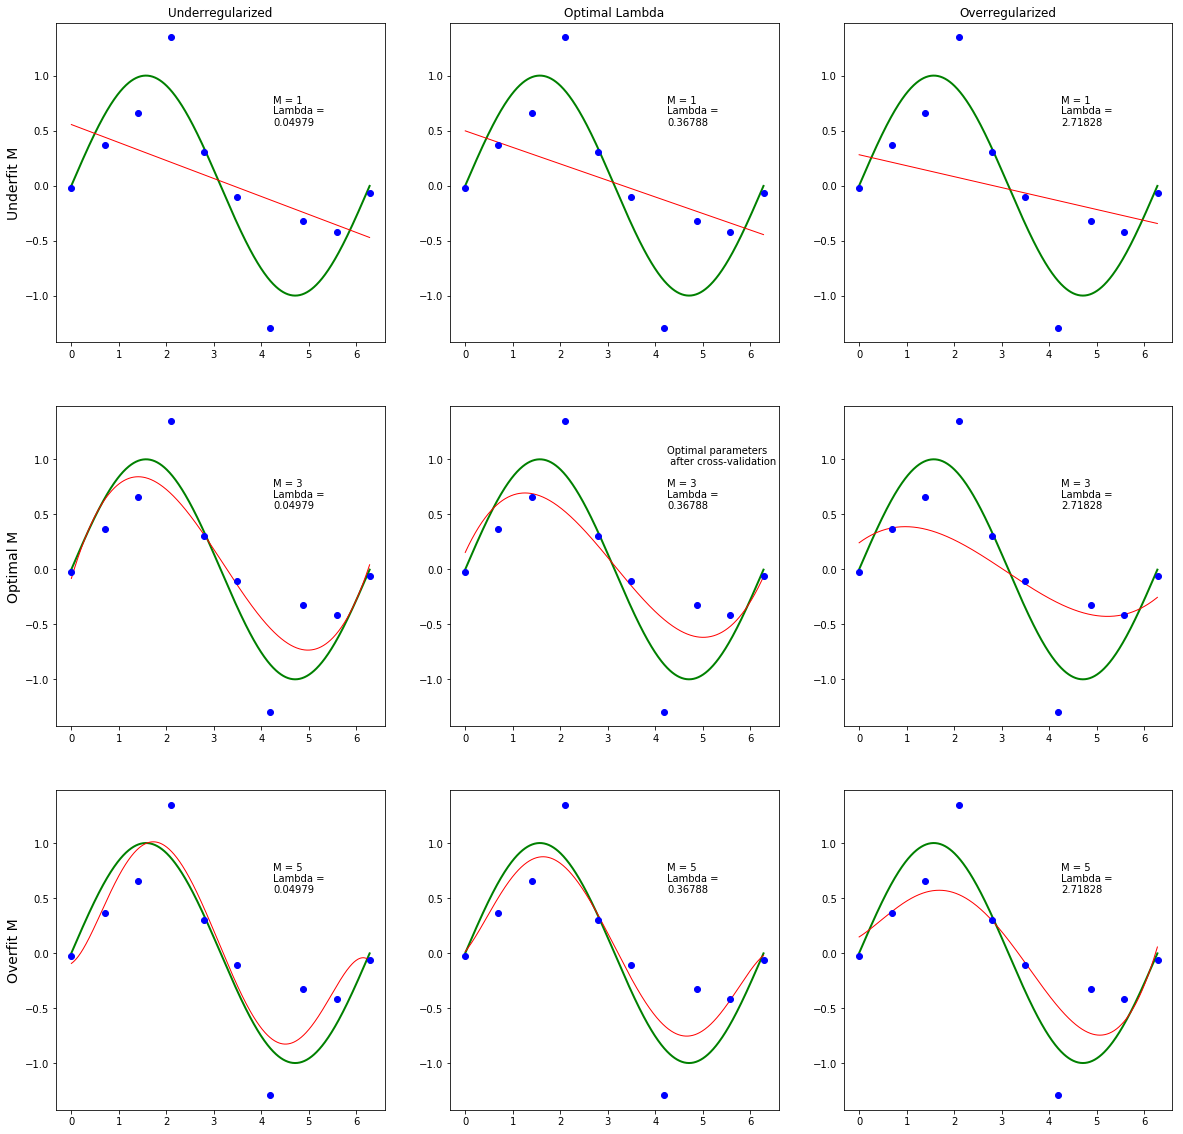

In [116]:
###For comparison we also include examples with too small and too large feature number, as well as under and overregularized models
###This gives us 3*3 plots, where the middle one is optimal in both parameters

fig = plt.figure(figsize = (20,20))

N = 10
x, t = gen_sine(N)
m_best, lamb_best = find_best_m_and_lamb(x,t)
labels_M = ["Underfit M", "Optimal M", "Overfit M"]
labels_Lambda = ["Underregularized", "Optimal Lambda", "Overregularized"]

# plot enumerator
i = 0

for m in [m_best - 2,m_best,m_best+2]:
    j = 1
    for lamb in [lamb_best/np.e**2,lamb_best,lamb_best*np.e**2]:
        
        pl = fig.add_subplot(3,3,(i*3) +j)
        
        w, Phi = fit_polynomial_reg(x, t, m, lamb)

        # get range of values on x-axis
        xx = np.arange(0.0, 2 * np.pi, 0.01)

        # plot true sin function
        y = np.sin(xx)
        pl.plot(xx, y, 'g', lw=2)

        # plot approximated sine
        y = build_polynomial(w, m, xx)
        pl.plot(xx, y, 'r', lw=1)

        # plot target points
        plt.plot(x, t, 'bo')
        
        if i == 1 and j == 2:
            plt.annotate("Optimal parameters\n after cross-validation", xy=(4.25, 0.95))
            
        plt.annotate('M = ' + str(m), xy=(4.25, 0.75))
        plt.annotate('Lambda = \n' + str('{0:.5f}'.format(lamb)), xy=(4.25, 0.55))
  

        
        if i == 0:
            pl.title.set_text(labels_Lambda[j-1])
        if j == 1:
            pl.set_ylabel(labels_M[i], fontsize=14)
        j = j+1

    i = i+1
    
plt.show()

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [117]:
def gen_sine2(n):
    x = np.sort(np.random.uniform(0, 2*np.pi, n))
    
    t = np.random.normal(np.sin(x), 0.25)  

    return x, t


In [118]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [119]:
def fit_polynomial_bayes(x, t, M, alpha, beta):

    # get feature matrix
    Phi = designmatrix(x,M)

    S = np.linalg.inv(alpha * np.identity(M+1) + beta * np.dot(np.transpose(Phi) , Phi))
    m = beta * np.dot(np.dot(S, np.transpose(Phi)), t)
    
    return m, S, Phi


In [120]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [121]:
def predict_polynomial_bayes(x, m, S, beta):
    
    Phi = designmatrix(x, m.shape[0]-1)
    
    mean = np.dot(Phi, m)
    sigma = np.diag(1/beta + np.dot(np.dot(Phi, S), np.transpose(Phi)))
    
    return mean, sigma, Phi


In [122]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


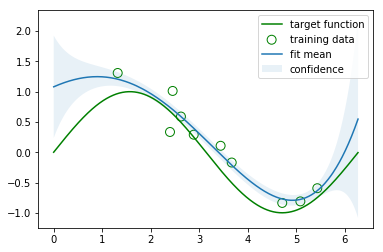

In [130]:
# Parameters

K = 1000 # number points to plot sine and plot of fit model

M = 4 # degree (number of basis functions)
alpha = 2/5 # prior precision
beta = 1/(0.25**2) # noise precision

# Generate data
train_x, train_t = gen_sine2(10)
test_x, _ = gen_sine2(K)

# Fit model on data
m, S, _ = fit_polynomial_bayes(train_x, train_t, M, alpha, beta)

# Get prediction on test data
mean, sigma, _ = predict_polynomial_bayes(test_x, m, S, beta)

# Plotting training data
plt_tdata = plt.scatter(train_x, train_t, edgecolors="green", s=80, facecolors="none")

# Plotting true sin function
plot_x = np.arange(0, 2*np.pi, (2/K)*np.pi)
plt_sin, = plt.plot(plot_x, np.sin(plot_x), color="green")

# Plot model with precision
plt_conf = plt.fill_between(test_x, mean+sigma, mean-sigma, alpha=0.1)
plt_mean, = plt.plot(test_x, mean)

# Show legend
_ = plt.legend([plt_sin, plt_tdata, plt_mean, plt_conf], ["target function", "training data", "fit mean", "confidence"])


b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


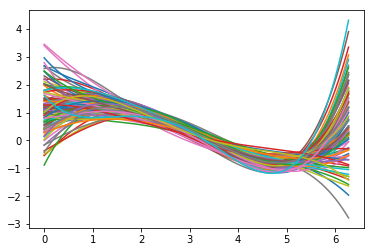

In [161]:
# Sample 100 parameters from multivariate normal distribution with mean and covatiance m and S
samples = np.random.multivariate_normal(m, S, 100)

# Get x values for plots
plot_x = np.arange(0, 2*np.pi, (2/K)*np.pi)

# Compute polynomials
plot_y =  build_polynomial(samples, samples.shape[1]-1, plot_x)

# Plot results
_ = plt.plot(plot_x, plot_y)

# Plot data
plt_tdata = plt.scatter(train_x, train_t, marker="x", edgecolors="black", s=80, facecolors="none")

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



The parameter beta is the noise precision, in other words, the inverse of the variance of the noise in our data. In most cases this has to be estimated, but in this case, we generated the noise by hand, sampling our data from a normal distribution with a standard deviation of 0.25, hence we know the exact noise precision value : 1/0.25^2 = 16

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

The basis functions let us preprocess the data also in a non-linear fashion so we can fit a linear model on the transformed data. However the choice of the basis functions is not straightforward: even though they can make non-linear problems linearly solvable, especially in high-dimensions it is hard the proper non-linear basis functions that would map the input into a linearly solvable task. Besides the problem of the mapping selection, in general it is complicated to select the proper number of functions to extract the important features from the data but not run into under/overfitting, and also it is difficult to determine whether we want our basis functions to act on the full range of the input, or we want to define a spline to act differently in different regions of the input.